In [1]:
import pandas as pd
import geopandas as gpd
import movingpandas as mpd
import numpy as np
from datetime import timedelta, datetime
from maritime_traffic_network import MaritimeTrafficNetwork
import folium
import warnings
import sys
import pickle
warnings.filterwarnings('ignore')

print("Geopandas has version {}".format(gpd.__version__))
print("Movingpandas has version {}".format(mpd.__version__))

Geopandas has version 0.13.2
Movingpandas has version 0.17.1


In [2]:
# add paths for modules
sys.path.append('../visualization')
sys.path.append('../features')
print(sys.path)

# import modules
import visualize

['/Users/janhendrikwebert/maritime_route_prediction/src/models', '/Users/janhendrikwebert/miniforge3/envs/env_geo/lib/python311.zip', '/Users/janhendrikwebert/miniforge3/envs/env_geo/lib/python3.11', '/Users/janhendrikwebert/miniforge3/envs/env_geo/lib/python3.11/lib-dynload', '', '/Users/janhendrikwebert/miniforge3/envs/env_geo/lib/python3.11/site-packages', '../visualization', '../features', '../visualization', '../features']


In [3]:
# read data from file
filename = '../../data/processed/202204_points_stavanger_cleaned_meta_full_dualSplit_2.parquet'
#filename = '../../data/processed/202204_points_stavanger_cleaned_meta_full.parquet'
gdf = gpd.read_parquet(filename)

In [4]:
# filter the data according to ship type
shiptypes = ['Tank', 'Last', 'Passasjer', None]
gdf = gdf[gdf.skipsgruppe.isin(shiptypes)]

In [5]:
# Transform to desired CRS
# 4326 for WGS 84 (global) // 32632 for UTM 32N (Norway)
crs = 32632  # Coordinate reference system
gdf.to_crs(crs, inplace=True)  # Transformation
gdf.head()

,mmsi,imo_nr,length,lon,lat,sog,cog,true_heading,nav_status,message_nr,bredde,dypgaaende,skipstype,skipsgruppe,fartoynavn,geometry,speed
date_time_utc,,,,,,,,,,,,,,,,,
2022-04-08 03:12:48,205209000_0_2022-04-08 03:12:48,0,51,5.36673,59.6732,10.6,225.9,225,0,1,NaN,NaN,None,None,None,POINT (295416.506 6620618.919),11.173331
2022-04-08 03:12:58,205209000_0_2022-04-08 03:12:48,0,51,5.36531,59.6725,10.7,227.2,228,0,1,NaN,NaN,None,None,None,POINT (295332.330 6620545.422),11.173331
2022-04-08 03:13:08,205209000_0_2022-04-08 03:12:48,0,51,5.36458,59.6722,10.6,228.8,230,0,1,NaN,NaN,None,None,None,POINT (295289.421 6620514.299),5.300198
2022-04-08 03:13:27,205209000_0_2022-04-08 03:12:48,0,51,5.36385,59.6718,10.5,229.4,229,0,1,NaN,NaN,None,None,None,POINT (295245.901 6620472.052),3.191942
2022-04-08 03:13:38,205209000_0_2022-04-08 03:12:48,0,51,5.36313,59.6715,10.5,225.2,223,0,1,NaN,NaN,None,None,None,POINT (295203.553 6620440.899),4.778771


In [6]:
# initialize maritime traffic network
network = MaritimeTrafficNetwork(gdf, crs)
network.get_trajectories_info()

Number of AIS messages: 4716292
Number of trajectories: 13403
Coordinate Reference System (CRS): EPSG:32632


In [7]:
# calculate significant turning points using Douglas Peucker algorithm
tolerance = 10 # DP tolerance parameter 0.0002
network.calc_significant_points_DP(tolerance)

Calculating significant turning points with Douglas Peucker algorithm (tolerance = 10) ...
Number of significant points detected: 360440 (7.64% of AIS messages)
Time elapsed: 4.04 minutes
Adding course over ground before and after each turn ...
Done. Time elapsed: 5.70 minutes


In [8]:
# detect waypoints using spatial clustering
method = 'HDBSCAN'      # 'DBSCAN' , 'HDBSCAN', 'OPTICS'
metric = 'mahalanobis'  # 'euclidean', 'mahalanobis', 'haversine'
min_samples = 15
min_cluster_size = 15
eps = 0
V = np.diag([1, 1, 0.01, 0.01, 1e-4])  # mahalanobis distance parameter matrix V = np.diag([1, 1, 0.01, 0.01, 1e-3])  seems to be good
network.calc_waypoints_clustering(method=method, min_samples=min_samples, min_cluster_size=min_cluster_size,
                                  eps=eps, metric=metric, V=V)

Calculating waypoints with HDBSCAN (min_samples = 15) ...
Distance metric: mahalanobis
1881 clusters detected
Time elapsed: 21.23 minutes


In [9]:
# make graph from waypoints
max_distance=10
max_angle=45
network.make_graph_from_waypoints(max_distance=max_distance, max_angle=max_angle)

Constructing maritime traffic network graph from waypoints and trajectories...
Progress: 10%...20%...30%...40%...50%...60%...70%...80%...90%...Done!
------------------------
Unpruned Graph:
Number of nodes: 1881 (38 isolated)
Number of edges: 9872
Network is (weakly) connected: False
------------------------
Time elapsed: 18.23 minutes


In [10]:
#network.prune_graph(1)

In [11]:
# save hyperparameters
params = {
    'Data':filename,
    'filter':shiptypes,
    'DP_tolerance':tolerance,
    'clustering_method':method,
    'clustering_metric':metric,
    'clustering_min_samples':min_samples,
    'clustering_min_cluster_size':min_cluster_size,
    'clustering_eps':eps,
    'clustering_metric_V':V,
    'graph_generation_max_distance':max_distance,
    'graph_generation_max_angle':max_angle
}
network.set_hyperparameters(params)

In [12]:
# save network as pickle object
fileObj = open('../../data/interim/202204_waypoints_DP10_HDBSCAN15_stavanger_full_UTM_filtered.obj', 'wb')
pickle.dump(network, fileObj)
fileObj.close()

In [13]:
# Generate plot
#network.prune_graph(2)
#map = network.map_graph(pruned=True)
#folium.LayerControl().add_to(map)

# add a title
#title = f'{method} parameters: min_samples = {min_samples}, metric = {metric}'
#title_html = '''
#             <h3 align="center" style="font-size:16px"><b>{}</b></h3>
#             '''.format(title)   

#map.get_root().html.add_child(folium.Element(title_html))

#map

In [14]:
#data = network.significant_points.drop('clusterID', axis=1)
#data.to_parquet('../../data/interim/202204_significant_points_DP10_stavanger_full_UTM.parquet')

In [15]:
#network.significant_points.to_parquet('../../data/interim/202204_significant_points_DP10_clustered_stavanger_full_UTM.parquet')

In [16]:
#cluster_centroids = network.waypoints
#cluster_centroids.set_geometry('convex_hull', inplace=True, crs=crs)
#cluster_centroids.to_parquet('../../data/interim/202204_waypoints_DP10_HDBSCAN30_stavanger_full_UTM.parquet')

In [17]:
model = '202204_waypoints_DP' + str(tolerance) + '_' + method + str(min_samples) +'_stavanger_full_UTM_filtered'
merge_stops = True
merge_stops_speed = 2
pruning = 1
network.merge_stop_points(max_speed=merge_stops_speed)
network.prune_graph(pruning)

------------------------
Pruned Graph:
Number of nodes: 1835 (17 isolated)
Number of edges: 9621
------------------------


In [18]:
# load evaluation data
eval_file = '202205_points_stavanger_cleaned_meta_full_dualSplit_2'
filename = '../../data/processed/' + eval_file + '.parquet'
gdf = gpd.read_parquet(filename)
gdf = gdf[gdf.skipsgruppe.isin(shiptypes)]
crs = 32632  # Coordinate reference system
gdf.to_crs(crs, inplace=True)  # Transformation
all_trajectories = mpd.TrajectoryCollection(gdf, traj_id_col='mmsi', obj_id_col='mmsi')

# select evaluation data
selection_start = 1
selection_end = len(all_trajectories)
selection_step = 10
selection = np.arange(selection_start, selection_end, selection_step)
n_trajectories = len(selection)
mmsis = gdf.mmsi.unique()[selection]
trajectories = all_trajectories.filter('mmsi', mmsis.tolist())

Evaluating graph on 1375 trajectories
Progress: 10%...20%...30%...40%...50%...60%...70%...80%...90%...Done!
Success rates:
                   mmsi  mean_dist  median_dist  max_dist  distances  fraction_covered
message                                                                               
attempt        0.034909   0.029818     0.029818  0.029818   0.034909          0.034909
no_intersects  0.069091   0.000000     0.000000  0.000000   0.000000          0.069091
no_path        0.115636   0.000000     0.000000  0.000000   0.000000          0.115636
success        0.780364   0.780364     0.780364  0.780364   0.780364          0.780364

 --------------------------- 

Fraction of NaN results: 0.190

 --------------------------- 

Mean fraction of each trajectory covered by the path on the graph: 0.897 

Mean distance      = 390.59 m
Median distance    = 107.23 m
Standard deviation = 1241.74 m 



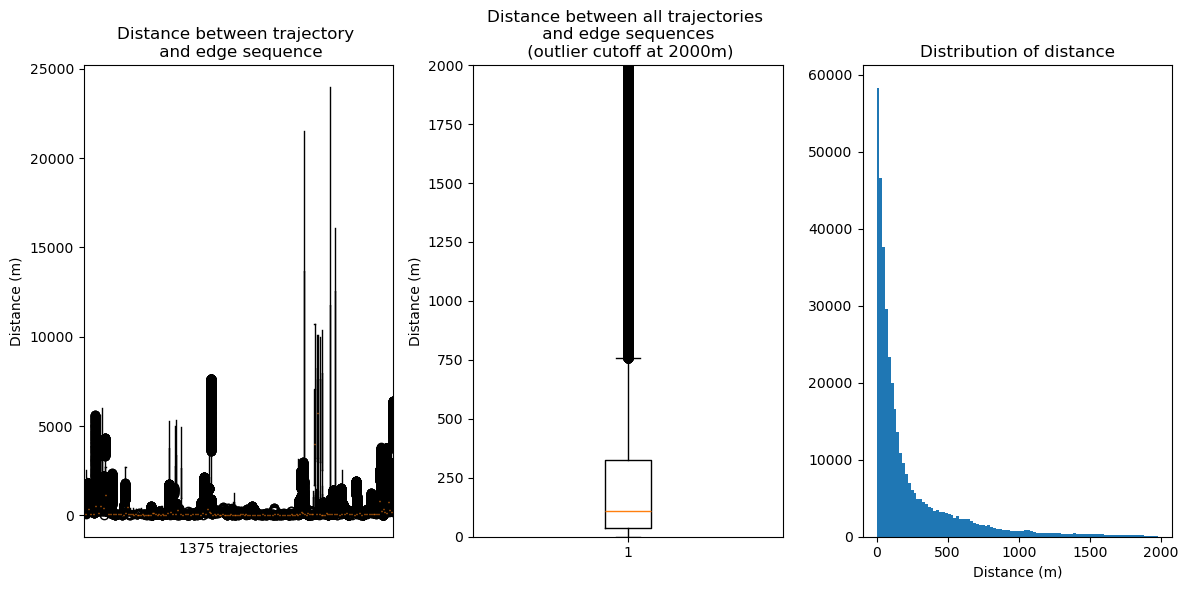

In [19]:
all_paths, all_evaluation_results, summary, fig = network.evaluate_graph(trajectories)
fig.show()

In [20]:
# Save experiment results with neptune
import neptune
import networkx as nx

run = neptune.init_run(
    project="jandrik91/Maritime-Traffic-Network",
    api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiIxYmQzMjgwZS1jZGYwLTQ2YjktYWNjOS02MjBlZWEzNzUzNDcifQ==",
)  # your credentials

run["model"]=model
run["n_points"]=len(network.gdf)
run["n_nodes"]=network.G_pruned.number_of_nodes()
run["n_edges"]=network.G_pruned.number_of_edges()
run["n_isolated"]=nx.number_of_isolates(network.G_pruned)
run["merge_stops"] = merge_stops
run["merge_stops_speed"] = merge_stops_speed
run["pruning"] = pruning

params = network.hyperparameters
params['clustering_metric_V_coord'] = params['clustering_metric_V'][0][0]
params['clustering_metric_V_cog'] = params['clustering_metric_V'][2][2]
params['clustering_metric_V_speed'] = params['clustering_metric_V'][4][4]
run["parameters"] = params

run["test_data"] = {'eval_file':eval_file,
                    'selection_start':selection_start,
                    'selection_end':selection_end,
                    'selection_step':selection_step,
                    'n_trajectories':n_trajectories}

run["plot"].upload(fig)
run["summary"] = summary

run.stop()

https://app.neptune.ai/jandrik91/Maritime-Traffic-Network/e/MAR-132
Shutting down background jobs, please wait a moment...
Done!
Waiting for the remaining 32 operations to synchronize with Neptune. Do not kill this process.
All 32 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/jandrik91/Maritime-Traffic-Network/e/MAR-132/metadata
